In [304]:
import matplotlib.pyplot as plt
import numpy as np
import random
import scipy.fftpack as spfft

%env CUDA_VISIBLE_DEVICES=0
import torch

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#import torch_dip_utils as utils
import math

import time

import pywt.data

env: CUDA_VISIBLE_DEVICES=0


In [305]:
LR = 1e-4 # learning rate
MOM = 0.9 # momentum
NUM_ITER = 100 # number iterations
WD = 1e-4 # weight decay for l2-regularization

INPUT_LEN = 2 # input len
INPUT_CHANS = 2 #number of channels in our input 

OUTPUT_CHANS = 1 #num channels in the net output
OUTPUT_LEN = 16

X_OUTPUT = np.arange(OUTPUT_LEN) #set up an axis for plotting wave outputs

NUM_MEASUREMENTS = OUTPUT_LEN

ALPHA_TV = 1e-4

In [306]:
CUDA = torch.cuda.is_available()
#CUDA = False
print(CUDA)

#save the correct datatype depending on CPU or GPU execution
if CUDA : 
    dtype = torch.cuda.FloatTensor  
    print(torch.cuda.device(0))
else:
    dtype = torch.FloatTensor
    print("NO DEVICES")

True


In [307]:
#INPUT_LEN = 32
#Latent size = output for input_chans = 4
class DCGAN(nn.Module):
    def __init__(self, input_chans=32, output_chans=1, num_measurements = 128, output_size = 128):
        super(DCGAN, self).__init__()
        self.nc = output_chans
        self.output_size = output_size
        self.CUDA = CUDA

        #for default case (32 input_chans) - #params = output_len
        #reduce input_chans to underparameterize, increase to overparameterize

        self.conv1 = nn.ConvTranspose1d(input_chans, output_chans, 8, 8, 0, bias=False) 
        
        self.fc = nn.Linear(output_size * output_chans, num_measurements, bias=False)

    def forward(self, x):
        x = self.conv1(x)

        return x
    
    def measurements(self, x):
        y = self.forward(x).view(1, -1)

        meas = self.fc(y).view(-1, 1)

        if self.CUDA:
            return meas.cuda()
        else:
            return meas

In [308]:
def TV_Loss(pred, y, alpha_TV):
    TV = torch.sum(torch.abs(pred[:-1, :] - pred[1:, :]))
    
    mse = torch.nn.MSELoss(reduction="sum").type(dtype)
    MSE = mse(pred, y)
    
    return MSE + alpha_TV*TV

In [309]:
y0 = np.zeros((OUTPUT_LEN, 1))
y0_denoised = np.sin(2 * np.pi *2*X_OUTPUT / OUTPUT_LEN)
y0[:,0] = np.sin(2 * np.pi *2*X_OUTPUT / OUTPUT_LEN)
y0[:,0] += 0.25 * np.random.randn(OUTPUT_LEN)

In [310]:
def get_stats(x):
    #a = np.min(x)
    #b = np.max(x)
    #mu = (a+b)/2.0
    #sigma = (b-a)/2.0
    #return [mu, sigma]
    mu = np.mean(x)
    sigma = np.std(x)
    return [mu, sigma]

def normalise(x, mu, sigma):
    return (x-mu)/sigma

def renormalise(x, mu, sigma):
    return x*sigma + mu

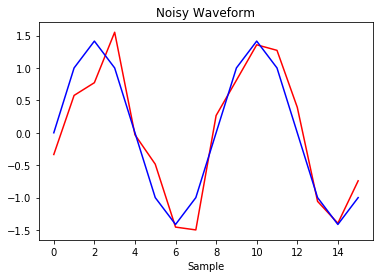

In [311]:
MU = get_stats(y0)[0]
SIGMA = get_stats(y0)[1]

y0 = normalise(y0, MU, SIGMA)

MU = get_stats(y0_denoised)[0]
SIGMA = get_stats(y0_denoised)[1]

y0_denoised = normalise(y0_denoised, MU, SIGMA)
#y0 = y0 - np.amin(y0)
plt.figure()
plt.plot(X_OUTPUT, y0, color='r')
plt.plot(X_OUTPUT, y0_denoised, color='b')
plt.xlabel("Sample")
plt.title("Noisy Waveform")
plt.show()

In [312]:
kept_samples = random.sample(range(0, OUTPUT_LEN), NUM_MEASUREMENTS)
imputed_samples = [z for z in range(0, OUTPUT_LEN) if z not in kept_samples]

A = np.eye(OUTPUT_LEN)[kept_samples, :]
print(A.shape)

y1 = np.dot(A, y0)
y2 = np.dot(A, y0_denoised)
print(y1.shape)

(16, 16)
(16, 1)


In [313]:
y = torch.Tensor(y1)
y = Variable(y.type(dtype))

if CUDA:
    y = y.cuda()
    
y_denoised = torch.Tensor(y2)
y_denoised = Variable(y_denoised.type(dtype))

if CUDA:
    y = y.cuda()
    y_denoised = y_denoised.cuda()

In [314]:
net = DCGAN(input_chans = INPUT_CHANS, output_chans = OUTPUT_CHANS, num_measurements=NUM_MEASUREMENTS, output_size = OUTPUT_LEN)
net.fc.weight.data = torch.Tensor(A)
net.fc.requires_grad = False

allparams = [x for x in net.parameters()]
allparams = allparams[:-1]

z = Variable(torch.zeros(INPUT_LEN * INPUT_CHANS).type(dtype).view(1,INPUT_CHANS,INPUT_LEN))
z.data.normal_().type(dtype)
z.requires_grad = False

if CUDA:
    net.cuda()
    print("USING CUDA")
else:
    print("RUNNING ON CPU")
    
params = sum([np.prod(p.size()) for p in allparams])
print(params) 

USING CUDA
16


In [315]:
optim = torch.optim.RMSprop(allparams,lr=LR,momentum=MOM, weight_decay=WD)

mse = torch.nn.MSELoss().type(dtype)

In [316]:
mse_log_true = np.zeros((NUM_ITER))
mse_log_noisy = np.zeros((NUM_ITER))

start = time.time()

#num_vis = np.arange(math.log10(NUM_ITER))
#vis = [(10**(e+1) - 1) for e in num_vis]
vis = range(0, int(NUM_ITER/2), int(NUM_ITER/20))
wave0 = torch.zeros(OUTPUT_LEN)

for i in range(NUM_ITER):
    optim.zero_grad()
    out = net(z)

    loss = mse(net.measurements(z), y) 
    #loss = TV_Loss(net.measurements(z), y, ALPHA_TV)
    
    
    wave = out[0].detach().reshape(-1, OUTPUT_CHANS).cpu().numpy()
    if i == NUM_ITER-1:
        wave0 = out[0].detach().reshape(-1, OUTPUT_CHANS)

    #mse_log_true[i] = np.mean((np.squeeze(y0_denoised)[kept_samples] - np.squeeze(wave)[kept_samples])**2)
    mse_log_noisy[i] = np.mean((np.squeeze(y0)[kept_samples] - np.squeeze(wave)[kept_samples])**2)
    """
    if i in vis:
        print(i)
        
        plt.figure()
        plt.plot(X_OUTPUT, y0)
        plt.plot(X_OUTPUT, wave)
        plt.xlabel("Sample")
        plt.ylabel("Value")
        plt.title("Final net Output")
        plt.show()
        
        #print("FINAL TEST MSE: ", mse_log_true[i])
        print("TRAIN MSE: ", mse_log_noisy[i])
    """ 
    
    loss.backward()
    optim.step()

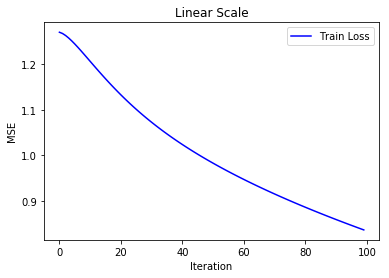

In [317]:
plt.figure()
#plt.plot(np.arange(NUM_ITER), mse_log_true, color='r', label='Test Loss')
plt.plot(np.arange(NUM_ITER), mse_log_noisy, color='b', label='Train Loss')
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("MSE")
#plt.xscale("log")
#plt.yscale("log")
#plt.ylim(0, 0.5)
#plt.xlim(10, 40)
plt.title('Linear Scale')
plt.show()


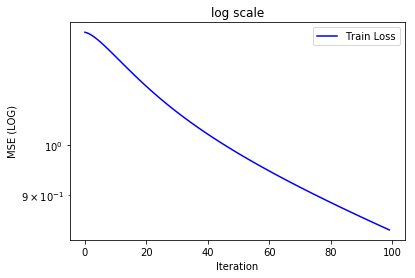

In [318]:
plt.figure()
#plt.plot(np.arange(NUM_ITER), mse_log_true, color='r', label='Test Loss')
plt.plot(np.arange(NUM_ITER), mse_log_noisy, color='b', label='Train Loss')
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("MSE (LOG)")
#plt.xscale("log")
plt.yscale("log")
#plt.ylim(0, 0.5)
#plt.xlim(10, 40)
plt.title('log scale')
plt.show()

In [319]:
f1 = net.conv1.weight.data[0,0,:]#.cpu().numpy()
f2 = net.conv1.weight.data[1,0,:]#.cpu().numpy()

print (f1)
print(f2)

tensor([-0.1397,  0.0960,  0.1495, -0.3329, -0.2352,  0.3227, -0.0824,  0.0033],
       device='cuda:0')
tensor([ 0.1919, -0.1078, -0.4632, -0.3600, -0.0420, -0.0736,  0.0259, -0.1323],
       device='cuda:0')


In [320]:
#z=view(1,INPUT_CHANS,INPUT_LEN))
z1 = z[0,0,:]#.cpu().numpy()
z2 = z[0,1,:]#.cpu().numpy()
print(z1)
print(z2)

tensor([-0.3105, -1.4003], device='cuda:0')
tensor([-0.6676, -0.4264], device='cuda:0')


In [321]:

print(wave0.shape)

torch.Size([16, 1])


In [322]:
m1 = torch.zeros((OUTPUT_LEN, INPUT_LEN)).cuda()
m2 = torch.zeros((OUTPUT_LEN, INPUT_LEN)).cuda()

m1[0:8, 0] = f1
m1[8:16, 1] = f1

m2[0:8, 0] = f2
m2[8:16, 1] = f2

print(m1)
print(m2)

tensor([[-0.1397,  0.0000],
        [ 0.0960,  0.0000],
        [ 0.1495,  0.0000],
        [-0.3329,  0.0000],
        [-0.2352,  0.0000],
        [ 0.3227,  0.0000],
        [-0.0824,  0.0000],
        [ 0.0033,  0.0000],
        [ 0.0000, -0.1397],
        [ 0.0000,  0.0960],
        [ 0.0000,  0.1495],
        [ 0.0000, -0.3329],
        [ 0.0000, -0.2352],
        [ 0.0000,  0.3227],
        [ 0.0000, -0.0824],
        [ 0.0000,  0.0033]], device='cuda:0')
tensor([[ 0.1919,  0.0000],
        [-0.1078,  0.0000],
        [-0.4632,  0.0000],
        [-0.3600,  0.0000],
        [-0.0420,  0.0000],
        [-0.0736,  0.0000],
        [ 0.0259,  0.0000],
        [-0.1323,  0.0000],
        [ 0.0000,  0.1919],
        [ 0.0000, -0.1078],
        [ 0.0000, -0.4632],
        [ 0.0000, -0.3600],
        [ 0.0000, -0.0420],
        [ 0.0000, -0.0736],
        [ 0.0000,  0.0259],
        [ 0.0000, -0.1323]], device='cuda:0')


tensor([-0.0847,  0.0422,  0.2629,  0.3437,  0.1011, -0.0511,  0.0083,  0.0873,
         0.1138, -0.0884, -0.0118,  0.6197,  0.3473, -0.4205,  0.1044,  0.0517],
       device='cuda:0')


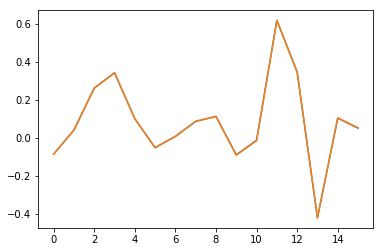

In [323]:
o = torch.matmul(m1, z1)
o += torch.matmul(m2, z2)

print(o)
plt.figure()
plt.plot(X_OUTPUT, o.cpu().numpy())
plt.plot(X_OUTPUT, wave0.cpu().numpy())
plt.show()

In [324]:
print(o-wave0[:,0])

tensor([-0.0006,  0.0011,  0.0012,  0.0012, -0.0004, -0.0011, -0.0012, -0.0012,
         0.0007,  0.0021,  0.0022,  0.0021,  0.0001, -0.0020, -0.0022, -0.0022],
       device='cuda:0')
